# 📊 Đánh giá Model trên TOÀN BỘ Dataset (800 frames)

## ⚡ QUICK START - Đọc Metrics Ngay

Nếu bạn ĐÃ CHẠY XONG và muốn XEM LẠI Precision/Recall/F1:
→ **Chạy cell bên dưới** để đọc từ file đã lưu!

In [1]:
# ⚡ QUICK VIEW - Xem Precision, Recall, F1 từ file đã lưu
import pandas as pd
from pathlib import Path

metrics_file = Path('predictions/full_dataset_metrics.csv')

if metrics_file.exists():
    print("="*70)
    print("✅ TÌM THẤY FILE METRICS ĐÃ LƯU!")
    print("="*70)
    
    df = pd.read_csv(metrics_file)
    
    # Hiển thị bảng đầy đủ
    print("\n📊 ALL METRICS AT DIFFERENT IoU THRESHOLDS:\n")
    print(df.to_string(index=False))
    
    # Highlight @ IoU 0.5
    metrics_05 = df[df['IoU'] == 0.5].iloc[0]
    
    print("\n" + "="*70)
    print("🎯 MAIN METRICS @ IoU 0.5 (STANDARD)")
    print("="*70 + "\n")
    
    precision = metrics_05['Precision']
    recall = metrics_05['Recall']
    f1 = metrics_05['F1']
    
    # Bảng đẹp
    print(f"┌{'─'*68}┐")
    print(f"│ {'METRIC':<20} │ {'VALUE':>15} │ {'STATUS':>28} │")
    print(f"├{'─'*68}┤")
    print(f"│ {'Precision':<20} │ {f'{precision:.2%}':>15} │ {('✅ Excellent' if precision >= 0.85 else '✅ Good' if precision >= 0.75 else '⚠️  Needs work'):>28} │")
    print(f"│ {'Recall':<20} │ {f'{recall:.2%}':>15} │ {('✅ TARGET MET!' if recall >= 0.85 else '✅ Good' if recall >= 0.75 else '⚠️  Needs work'):>28} │")
    print(f"│ {'F1-Score':<20} │ {f'{f1:.2%}':>15} │ {('✅ Excellent' if f1 >= 0.85 else '✅ Good' if f1 >= 0.75 else '⚠️  Needs work'):>28} │")
    print(f"└{'─'*68}┘\n")
    
    if 'TP' in metrics_05:
        print(f"📈 Confusion Matrix:")
        print(f"   • True Positives:  {int(metrics_05['TP']):,}")
        print(f"   • False Positives: {int(metrics_05['FP']):,}")
        print(f"   • False Negatives: {int(metrics_05['FN']):,}")
    
    print(f"\n💡 Summary:")
    print(f"   • {precision*100:.1f}% of detections are correct")
    print(f"   • {recall*100:.1f}% of real cells were found")
    print(f"   • {(1-recall)*100:.1f}% were missed")
    
    if recall >= 0.85:
        print(f"\n🎉🎉🎉 RECALL TARGET ACHIEVED! ({recall:.1%} ≥ 85%)")
    else:
        print(f"\n💪 Need {(0.85-recall)*100:.1f}% more recall to reach target")
        print(f"💡 Try: Lower prob_threshold to 0.2-0.3")
    
else:
    print("="*70)
    print("❌ CHƯA CÓ FILE METRICS")
    print("="*70)
    print("\n💡 Bạn cần:")
    print("   1. Có ground truth annotations")
    print("   2. Chạy các cell bên dưới để tính metrics")
    print("   3. File sẽ được lưu tại: predictions/full_dataset_metrics.csv")
    print("\n→ SCROLL XUỐNG và chạy từng phần theo hướng dẫn!")

❌ CHƯA CÓ FILE METRICS

💡 Bạn cần:
   1. Có ground truth annotations
   2. Chạy các cell bên dưới để tính metrics
   3. File sẽ được lưu tại: predictions/full_dataset_metrics.csv

→ SCROLL XUỐNG và chạy từng phần theo hướng dẫn!


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
from PIL import Image
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from csbdeep.utils import normalize
from stardist import random_label_cmap
from stardist.models import StarDist2D
from stardist.matching import matching_dataset

lbl_cmap = random_label_cmap()
plt.rcParams['figure.figsize'] = (14, 8)

---

# 🔍 KIỂM TRA: Có Ground Truth không?

## Bước đầu tiên: Xác định xem bạn có ground truth hay không

In [3]:
# Đường dẫn
frames_dir = Path('frames')
predictions_dir = Path('predictions/masks')
ground_truth_dir = Path('ground_truth_800_frames')  # Nơi chứa ground truth cho 800 ảnh

# Kiểm tra
frame_files = sorted(frames_dir.glob('frame_*.png'))
pred_files = sorted(predictions_dir.glob('frame_*.png'))
gt_files = sorted(ground_truth_dir.glob('frame_*.png')) if ground_truth_dir.exists() else []

print("="*70)
print("📋 DATASET STATUS CHECK")
print("="*70)
print(f"\n📂 Frames (input images): {len(frame_files)} files")
print(f"📂 Predictions (model output): {len(pred_files)} files")
print(f"📂 Ground Truth (annotations): {len(gt_files)} files")

if len(gt_files) == 0:
    print("\n❌ KHÔNG TÌM THẤY GROUND TRUTH!")
    print("\n💡 BẠN CẦN TẠO GROUND TRUTH TRƯỚC:")
    print("   1. Manual annotation: Dùng Napari/QuPath/ImageJ")
    print("   2. Semi-auto: Dùng model + manual correction")
    print("   3. Sample subset: Annotate 100-200 ảnh đại diện")
    print("\n→ Sau khi có ground truth, đặt vào folder: ground_truth_800_frames/")
    print("→ Sau đó chạy lại notebook này")
    has_ground_truth = False
elif len(gt_files) < len(frame_files):
    print(f"\n⚠️ Ground truth CHƯA ĐỦ: {len(gt_files)}/{len(frame_files)}")
    print(f"\n💡 BẠN CÓ {len(gt_files)} ground truth:")
    print(f"   → Có thể tính metrics trên {len(gt_files)} ảnh có GT")
    print(f"   → Hoặc tiếp tục annotate thêm {len(frame_files)-len(gt_files)} ảnh")
    has_ground_truth = True
else:
    print(f"\n✅✅✅ CÓ ĐỦ GROUND TRUTH!")
    print(f"   → Sẵn sàng tính metrics trên {len(gt_files)} ảnh")
    has_ground_truth = True

print("\n" + "="*70)

📋 DATASET STATUS CHECK

📂 Frames (input images): 886 files
📂 Predictions (model output): 886 files
📂 Ground Truth (annotations): 0 files

❌ KHÔNG TÌM THẤY GROUND TRUTH!

💡 BẠN CẦN TẠO GROUND TRUTH TRƯỚC:
   1. Manual annotation: Dùng Napari/QuPath/ImageJ
   2. Semi-auto: Dùng model + manual correction
   3. Sample subset: Annotate 100-200 ảnh đại diện

→ Sau khi có ground truth, đặt vào folder: ground_truth_800_frames/
→ Sau đó chạy lại notebook này



---

# PHẦN A: TÍNH METRICS (NẾU ĐÃ CÓ GROUND TRUTH)

## 📊 Chạy phần này nếu bạn ĐÃ CÓ ground truth

## ⚡ LƯU Ý QUAN TRỌNG

**Sau khi chạy PHẦN B hoặc C để tạo ground truth:**

1. ✅ Đặt ground truth masks vào folder: `ground_truth_800_frames/`
2. ✅ **CHẠY LẠI CÁC CELL BÊN DƯỚI** (không cần chạy lại cell kiểm tra ở trên)
3. ✅ Mỗi cell sẽ **TỰ ĐỘNG KIỂM TRA LẠI** ground truth

**Không cần lo về biến `has_ground_truth` cũ!** Các cell đã được sửa để tự kiểm tra.

In [4]:
# ⚡ KIỂM TRA NHANH - Có ground truth chưa?
from pathlib import Path

gt_dir = Path('ground_truth_800_frames')
if gt_dir.exists():
    gt_count = len(list(gt_dir.glob('frame_*.png')))
    if gt_count > 0:
        print(f"✅✅✅ CÓ {gt_count} GROUND TRUTH FILES!")
        print(f"\n→ Bạn có thể chạy các cell bên dưới để tính metrics!")
    else:
        print(f"❌ Folder tồn tại nhưng RỖNG!")
        print(f"\n→ Thêm ground truth vào: {gt_dir}/")
else:
    print(f"❌ CHƯA CÓ GROUND TRUTH!")
    print(f"\n→ Chạy PHẦN B hoặc PHẦN C để tạo ground truth")
    print(f"→ Hoặc tạo folder: {gt_dir}/")
    print(f"→ Và copy ground truth masks vào đó")

❌ CHƯA CÓ GROUND TRUTH!

→ Chạy PHẦN B hoặc PHẦN C để tạo ground truth
→ Hoặc tạo folder: ground_truth_800_frames/
→ Và copy ground truth masks vào đó


In [5]:
if not has_ground_truth:
    print("⚠️ Bỏ qua - Chưa có ground truth")
    print("   Chạy PHẦN B hoặc PHẦN C bên dưới")
else:
    print("="*70)
    print("🚀 LOADING DATA FOR METRICS CALCULATION")
    print("="*70)
    
    # Xác định số lượng ảnh để evaluate
    n_available = min(len(gt_files), len(pred_files))
    
    # Tùy chọn: Evaluate toàn bộ hoặc sample
    USE_ALL = True  # ← Đổi thành False nếu muốn test trên subset
    
    if USE_ALL:
        n_eval = n_available
        print(f"\n📊 Sẽ evaluate trên TOÀN BỘ {n_eval} ảnh")
    else:
        n_eval = min(100, n_available)  # Test trên 100 ảnh trước
        print(f"\n📊 Sẽ evaluate trên {n_eval}/{n_available} ảnh (test mode)")
    
    # Load ground truth và predictions
    print(f"\n⏳ Loading {n_eval} ground truth masks...")
    Y_true = []
    for gt_file in tqdm(gt_files[:n_eval], desc="Loading GT"):
        mask = np.array(Image.open(gt_file))
        Y_true.append(mask)
    
    print(f"\n⏳ Loading {n_eval} prediction masks...")
    Y_pred = []
    for pred_file in tqdm(pred_files[:n_eval], desc="Loading Pred"):
        mask = np.array(Image.open(pred_file))
        Y_pred.append(mask)
    
    print(f"\n✅ Loaded successfully:")
    print(f"   Ground Truth: {len(Y_true)} masks")
    print(f"   Predictions:  {len(Y_pred)} masks")
    
    # Thống kê nhanh
    total_gt_cells = sum([len(np.unique(y))-1 for y in Y_true])
    total_pred_cells = sum([len(np.unique(y))-1 for y in Y_pred])
    
    print(f"\n📊 Cell counts:")
    print(f"   Ground Truth: {total_gt_cells} cells")
    print(f"   Predictions:  {total_pred_cells} cells")
    print(f"   Difference:   {total_pred_cells - total_gt_cells:+d} cells")
    print(f"   Ratio:        {total_pred_cells/total_gt_cells:.2f}x")

⚠️ Bỏ qua - Chưa có ground truth
   Chạy PHẦN B hoặc PHẦN C bên dưới


## 📈 Tính Metrics tại nhiều IoU thresholds

In [6]:
if not has_ground_truth:
    print("⚠️ Bỏ qua - Chưa có ground truth")
else:
    print("="*70)
    print("📊 COMPUTING METRICS AT MULTIPLE IoU THRESHOLDS")
    print("="*70)
    
    iou_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    metrics_results = []
    
    for thresh in iou_thresholds:
        print(f"\n⏳ Computing metrics at IoU={thresh:.1f}...")
        
        stats = matching_dataset(
            Y_true, Y_pred, 
            thresh=thresh, 
            show_progress=True
        )
        
        metrics_results.append({
            'IoU': thresh,
            'Precision': stats.precision,
            'Recall': stats.recall,
            'F1': stats.f1,
            'AP': stats.mean_matched_score,
            'TP': stats.tp,
            'FP': stats.fp,
            'FN': stats.fn
        })
        
        print(f"   Precision: {stats.precision:.3f}")
        print(f"   Recall:    {stats.recall:.3f}")
        print(f"   F1-Score:  {stats.f1:.3f}")
    
    # Convert to DataFrame
    df_metrics = pd.DataFrame(metrics_results)
    
    # Save results
    output_file = Path('predictions/full_dataset_metrics.csv')
    df_metrics.to_csv(output_file, index=False)
    
    print(f"\n✅ Metrics saved to: {output_file}")
    print(f"\n{'='*70}")
    print("📊 FULL METRICS TABLE")
    print(f"{'='*70}")
    print(df_metrics.to_string(index=False))

⚠️ Bỏ qua - Chưa có ground truth


## 🎯 Phân tích chi tiết @ IoU 0.5

In [7]:
if not has_ground_truth:
    print("⚠️ Bỏ qua - Chưa có ground truth")
else:
    # Lấy metrics tại IoU 0.5 (standard)
    main_metrics = df_metrics[df_metrics['IoU'] == 0.5].iloc[0]
    
    precision = main_metrics['Precision']
    recall = main_metrics['Recall']
    f1 = main_metrics['F1']
    tp = int(main_metrics['TP'])
    fp = int(main_metrics['FP'])
    fn = int(main_metrics['FN'])
    
    print("="*70)
    print(f"📊 DETAILED ANALYSIS @ IoU 0.5 ({n_eval} images)")
    print("="*70)
    
    print(f"\n🎯 MAIN METRICS:")
    print(f"   Precision:  {precision:.1%}")
    print(f"   Recall:     {recall:.1%}")
    print(f"   F1-Score:   {f1:.1%}")
    
    print(f"\n📈 CONFUSION MATRIX:")
    print(f"   True Positives (TP):  {tp:,} cells")
    print(f"   False Positives (FP): {fp:,} cells")
    print(f"   False Negatives (FN): {fn:,} cells")
    
    print(f"\n💡 INTERPRETATION:")
    print(f"   → Model phát hiện ĐÚNG: {tp:,} cells")
    print(f"   → Phát hiện SAI (noise): {fp:,} cells")
    print(f"   → BỎ SÓT: {fn:,} cells")
    
    print(f"\n📊 PERCENTAGES:")
    total_gt = tp + fn
    total_pred = tp + fp
    print(f"   Ground Truth có: {total_gt:,} cells")
    print(f"   Model detect:    {total_pred:,} cells")
    print(f"   Phát hiện được:  {recall:.1%} ({tp:,}/{total_gt:,})")
    print(f"   Bỏ sót:          {(1-recall):.1%} ({fn:,}/{total_gt:,})")
    print(f"   False positive rate: {fp/total_pred if total_pred > 0 else 0:.1%}")
    
    # Đánh giá
    print(f"\n{'='*70}")
    print("🎓 EVALUATION")
    print(f"{'='*70}")
    
    if recall >= 0.85 and precision >= 0.85:
        print(f"\n✅✅✅ XUẤT SẮC!")
        print(f"   Model đạt cả 2 mục tiêu: Precision và Recall >= 85%")
    elif recall >= 0.85:
        print(f"\n✅✅ RECALL ĐẠT MỤC TIÊU! ({recall:.1%} >= 85%)")
        if precision < 0.75:
            print(f"   ⚠️ Nhưng Precision hơi thấp ({precision:.1%})")
            print(f"   💡 Tăng prob_threshold để giảm false positives")
    elif recall >= 0.75:
        print(f"\n✅ RECALL TỐT ({recall:.1%})")
        print(f"   💡 Gần đạt mục tiêu 85%, có thể cải thiện thêm")
        print(f"   → Giảm prob_threshold xuống 0.25-0.3")
    else:
        print(f"\n⚠️ RECALL CẦN CẢI THIỆN ({recall:.1%} < 75%)")
        print(f"\n💡 KHUYẾN NGHỊ:")
        print(f"   1. Giảm prob_threshold xuống 0.2-0.3")
        print(f"   2. Train lại với data augmentation mạnh hơn")
        print(f"   3. Tăng n_rays lên 96 hoặc 128")
        print(f"   4. Kiểm tra quality của ground truth annotations")
    
    print(f"\n{'='*70}")

⚠️ Bỏ qua - Chưa có ground truth


## 🎯 QUICK METRICS DISPLAY

### Xem nhanh Precision, Recall, F1-Score tại đây!

In [9]:
# ⚡ Kiểm tra lại metrics
if 'precision' not in locals() or 'recall' not in locals():
    print("❌ CHƯ A TÍNH METRICS!")
    print("\n💡 Bạn cần:")
    print("   1. CHẠY CÁC CELL Ở TRÊN để tính metrics TRƯỚC")
    print("   2. Hoặc xem kết quả cũ từ file bằng cell đầu notebook")
    print("\n→ Sau đó chạy lại cell này!")
else:
    # === HIỂN THỊ METRICS CHÍNH TẠI ĐÂY ===
    print("\n" + "="*70)
    print("🎯 PRECISION, RECALL, F1-SCORE @ IoU 0.5")
    print("="*70 + "\n")
    
    # In lớn và rõ ràng
    print(f"┌{'─'*68}┐")
    print(f"│ {'METRIC':<20} │ {'VALUE':>15} │ {'STATUS':>28} │")
    print(f"├{'─'*68}┤")
    print(f"│ {'Precision':<20} │ {f'{precision:.2%}':>15} │ {('✅ Excellent' if precision >= 0.85 else '✅ Good' if precision >= 0.75 else '⚠️  Needs work'):>28} │")
    print(f"│ {'Recall':<20} │ {f'{recall:.2%}':>15} │ {('✅ Excellent' if recall >= 0.85 else '✅ Good' if recall >= 0.75 else '⚠️  Needs work'):>28} │")
    print(f"│ {'F1-Score':<20} │ {f'{f1:.2%}':>15} │ {('✅ Excellent' if f1 >= 0.85 else '✅ Good' if f1 >= 0.75 else '⚠️  Needs work'):>28} │")
    print(f"└{'─'*68}┘\n")
    
    print(f"📊 Confusion Matrix:")
    print(f"   • True Positives (TP):  {tp:,}")
    print(f"   • False Positives (FP): {fp:,}")
    print(f"   • False Negatives (FN): {fn:,}")
    
    print(f"\n💡 Interpretation:")
    print(f"   • Precision {precision:.1%}: {precision*100:.1f}% detected cells are CORRECT")
    print(f"   • Recall {recall:.1%}: Found {recall*100:.1f}% of all real cells")
    print(f"   • F1-Score {f1:.1%}: Overall balance score")
    

    if recall >= 0.85:        
        print(f"\n💪 Need {(0.85-recall)*100:.1f}% more to reach 85% recall target")
   
    else:
        print(f"\n🎉 TARGET ACHIEVED! Recall ≥ 85%") 

❌ CHƯ A TÍNH METRICS!

💡 Bạn cần:
   1. CHẠY CÁC CELL Ở TRÊN để tính metrics TRƯỚC
   2. Hoặc xem kết quả cũ từ file bằng cell đầu notebook

→ Sau đó chạy lại cell này!


## 📊 Visualize Metrics

In [10]:
if not has_ground_truth:
    print("⚠️ Bỏ qua - Chưa có ground truth")
else:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Metrics vs IoU
    ax = axes[0, 0]
    ax.plot(df_metrics['IoU'], df_metrics['Precision'], 'o-', linewidth=2, label='Precision', color='blue')
    ax.plot(df_metrics['IoU'], df_metrics['Recall'], 's-', linewidth=2, label='Recall', color='green')
    ax.plot(df_metrics['IoU'], df_metrics['F1'], '^-', linewidth=2, label='F1-Score', color='red')
    ax.axhline(0.85, color='gray', linestyle='--', alpha=0.5, label='Target 85%')
    ax.set_xlabel('IoU Threshold', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(f'Metrics vs IoU Threshold ({n_eval} images)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_ylim([0, 1])
    
    # Plot 2: Precision-Recall curve
    ax = axes[0, 1]
    ax.plot(df_metrics['Recall'], df_metrics['Precision'], 'o-', linewidth=2, markersize=10, color='purple')
    for i, row in df_metrics.iterrows():
        ax.annotate(f"IoU={row['IoU']:.1f}", 
                   (row['Recall'], row['Precision']),
                   textcoords="offset points", xytext=(10,5), fontsize=9)
    ax.axhline(0.85, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(0.85, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title('Precision-Recall Trade-off', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    # Plot 3: Confusion Matrix @ IoU 0.5
    ax = axes[1, 0]
    categories = ['True\nPositives', 'False\nPositives', 'False\nNegatives']
    values = [tp, fp, fn]
    colors = ['green', 'orange', 'red']
    bars = ax.bar(categories, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Confusion Matrix @ IoU 0.5', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{val:,}',
               ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Plot 4: Summary text
    ax = axes[1, 1]
    ax.axis('off')
    
    summary_text = f"""
EVALUATION SUMMARY
{'='*50}

Dataset: {n_eval} images
Total GT cells: {total_gt:,}
Total Pred cells: {total_pred:,}

METRICS @ IoU 0.5:
  • Precision:  {precision:.1%}
  • Recall:     {recall:.1%}
  • F1-Score:   {f1:.1%}

CONFUSION MATRIX:
  • True Positives:  {tp:,}
  • False Positives: {fp:,}
  • False Negatives: {fn:,}

PERFORMANCE:
  • Detected correctly: {recall:.1%}
  • Missed (FN):        {(1-recall):.1%}
  • False alarm rate:   {fp/total_pred if total_pred > 0 else 0:.1%}

STATUS:
{'  ✅ EXCELLENT!' if recall >= 0.85 and precision >= 0.85 else ''}
{'  ✅ RECALL TARGET MET!' if recall >= 0.85 and precision < 0.85 else ''}
{'  ⚠️  NEEDS IMPROVEMENT' if recall < 0.75 else ''}
"""
    
    ax.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
           verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig('predictions/full_dataset_metrics_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Visualization saved to: predictions/full_dataset_metrics_visualization.png")

⚠️ Bỏ qua - Chưa có ground truth


## 🔍 Phân tích Per-Image (tìm ảnh có vấn đề)

In [11]:
if not has_ground_truth:
    print("⚠️ Bỏ qua - Chưa có ground truth")
else:
    print("="*70)
    print("🔍 PER-IMAGE ANALYSIS")
    print("="*70)
    
    # Tính metrics cho từng ảnh
    per_image_results = []
    
    print(f"\n⏳ Analyzing {n_eval} images individually...")
    for i, (y_true, y_pred) in enumerate(tqdm(zip(Y_true, Y_pred), total=n_eval)):
        # Count
        n_true = len(np.unique(y_true)) - 1
        n_pred = len(np.unique(y_pred)) - 1
        
        # Match
        stats = matching_dataset([y_true], [y_pred], thresh=0.5, show_progress=False)
        
        per_image_results.append({
            'image': gt_files[i].name,
            'n_true': n_true,
            'n_pred': n_pred,
            'precision': stats.precision,
            'recall': stats.recall,
            'f1': stats.f1,
            'tp': stats.tp,
            'fp': stats.fp,
            'fn': stats.fn
        })
    
    df_per_image = pd.DataFrame(per_image_results)
    df_per_image.to_csv('predictions/per_image_metrics.csv', index=False)
    
    print(f"\n✅ Per-image metrics saved to: predictions/per_image_metrics.csv")
    
    # Tìm ảnh có vấn đề
    print(f"\n{'='*70}")
    print("⚠️ IMAGES WITH LOW RECALL (<70%)")
    print(f"{'='*70}")
    
    low_recall = df_per_image[df_per_image['recall'] < 0.7].sort_values('recall')
    if len(low_recall) > 0:
        print(f"\nFound {len(low_recall)} images with recall < 70%:\n")
        print(low_recall[['image', 'n_true', 'n_pred', 'recall', 'fn']].head(10).to_string(index=False))
        print(f"\n💡 Những ảnh này cần kiểm tra lại:")
        print(f"   - Có thể annotations chưa chính xác")
        print(f"   - Hoặc ảnh quá khó (cells nhỏ, chồng lấp nhiều)")
    else:
        print("\n✅ Không có ảnh nào có recall < 70%")
    
    print(f"\n{'='*70}")
    print("⚠️ IMAGES WITH LOW PRECISION (<70%)")
    print(f"{'='*70}")
    
    low_precision = df_per_image[df_per_image['precision'] < 0.7].sort_values('precision')
    if len(low_precision) > 0:
        print(f"\nFound {len(low_precision)} images with precision < 70%:\n")
        print(low_precision[['image', 'n_true', 'n_pred', 'precision', 'fp']].head(10).to_string(index=False))
        print(f"\n💡 Những ảnh này có nhiều false positives")
    else:
        print("\n✅ Không có ảnh nào có precision < 70%")

⚠️ Bỏ qua - Chưa có ground truth


---

# PHẦN B: TẠO GROUND TRUTH (NẾU CHƯA CÓ)

## 💡 Hướng dẫn tạo ground truth cho 800 ảnh

### Phương pháp 1: Sample-based Evaluation (KHUYẾN NGHỊ)
**Không cần annotate cả 800 ảnh!** Chỉ cần:
- Chọn ngẫu nhiên 100-200 ảnh đại diện
- Annotate kỹ 100-200 ảnh này
- Metrics trên subset này sẽ đại diện cho toàn bộ dataset

**Ưu điểm:** Nhanh, chính xác đủ dùng

### Phương pháp 2: Semi-automatic Annotation
1. Dùng model predict trên 800 ảnh
2. Manual review + correction trên các ảnh có confidence thấp
3. Tạo ground truth từ predictions đã correct

**Ưu điểm:** Nhanh hơn annotate từ đầu

### Phương pháp 3: Full Manual Annotation
- Dùng Napari, QuPath, hoặc ImageJ
- Annotate cả 800 ảnh (rất tốn thời gian!)

**Ưu điểm:** Chính xác nhất nhưng MẤT THỜI GIAN

## 🎲 Chọn ngẫu nhiên 100 ảnh để annotate

In [12]:
if has_ground_truth:
    print("✅ Đã có ground truth - bỏ qua phần này")
else:
    print("="*70)
    print("🎲 SELECTING SAMPLE FOR ANNOTATION")
    print("="*70)
    
    # Chọn 100 ảnh ngẫu nhiên
    np.random.seed(42)  # Reproducible
    n_sample = 100
    
    if len(frame_files) < n_sample:
        sample_indices = np.arange(len(frame_files))
    else:
        sample_indices = np.random.choice(len(frame_files), n_sample, replace=False)
    
    sample_files = [frame_files[i] for i in sorted(sample_indices)]
    
    # Tạo folder
    sample_dir = Path('annotation_sample_100')
    sample_dir.mkdir(exist_ok=True)
    
    # Copy các ảnh được chọn
    print(f"\n📁 Copying {len(sample_files)} images to {sample_dir}/...")
    for f in tqdm(sample_files, desc="Copying"):
        import shutil
        shutil.copy2(f, sample_dir / f.name)
    
    # Lưu danh sách
    with open(sample_dir / 'selected_files.txt', 'w') as f:
        for file in sample_files:
            f.write(f"{file.name}\n")
    
    print(f"\n✅ Sample created successfully!")
    print(f"\n📋 NEXT STEPS:")
    print(f"   1. Mở folder: {sample_dir}/")
    print(f"   2. Annotate {len(sample_files)} ảnh bằng Napari/QuPath/ImageJ")
    print(f"   3. Lưu masks vào: ground_truth_800_frames/")
    print(f"   4. Chạy lại notebook này để tính metrics")
    
    print(f"\n💡 TIP: Dùng script 'advanced_annotation.py' để annotate nhanh hơn!")

🎲 SELECTING SAMPLE FOR ANNOTATION

📁 Copying 100 images to annotation_sample_100/...


Copying: 100%|██████████| 100/100 [00:00<00:00, 305.56it/s]


✅ Sample created successfully!

📋 NEXT STEPS:
   1. Mở folder: annotation_sample_100/
   2. Annotate 100 ảnh bằng Napari/QuPath/ImageJ
   3. Lưu masks vào: ground_truth_800_frames/
   4. Chạy lại notebook này để tính metrics

💡 TIP: Dùng script 'advanced_annotation.py' để annotate nhanh hơn!


---

# PHẦN C: ĐÁNH GIÁ ĐỊNH TÍNH (KHÔNG CẦN GROUND TRUTH)

## 📊 Phân tích confidence và visual inspection

In [13]:
if has_ground_truth:
    print("✅ Đã có ground truth và đã tính metrics ở trên")
    print("   Có thể bỏ qua phần này")
else:
    print("="*70)
    print("📊 QUALITATIVE ANALYSIS (WITHOUT GROUND TRUTH)")
    print("="*70)
    print("\nSẽ phân tích dựa trên:")
    print("  • Confidence scores của predictions")
    print("  • Cell size distribution")
    print("  • Visual consistency")
    
    # Load model
    print("\n⏳ Loading model...")
    model_name = 'stardist_my_data_v2_improved'
    model_basedir = 'models'
    model = StarDist2D(None, name=model_name, basedir=model_basedir)
    
    print(f"✅ Model loaded: {model_name}")
    print(f"   Thresholds: prob={model.thresholds.prob:.3f}, nms={model.thresholds.nms:.3f}")

📊 QUALITATIVE ANALYSIS (WITHOUT GROUND TRUTH)

Sẽ phân tích dựa trên:
  • Confidence scores của predictions
  • Cell size distribution
  • Visual consistency

⏳ Loading model...
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.489673, nms_thresh=0.3.
✅ Model loaded: stardist_my_data_v2_improved
   Thresholds: prob=0.490, nms=0.300


## 📈 Phân tích Confidence Distribution

⏳ Analyzing confidence scores...


Analyzing: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


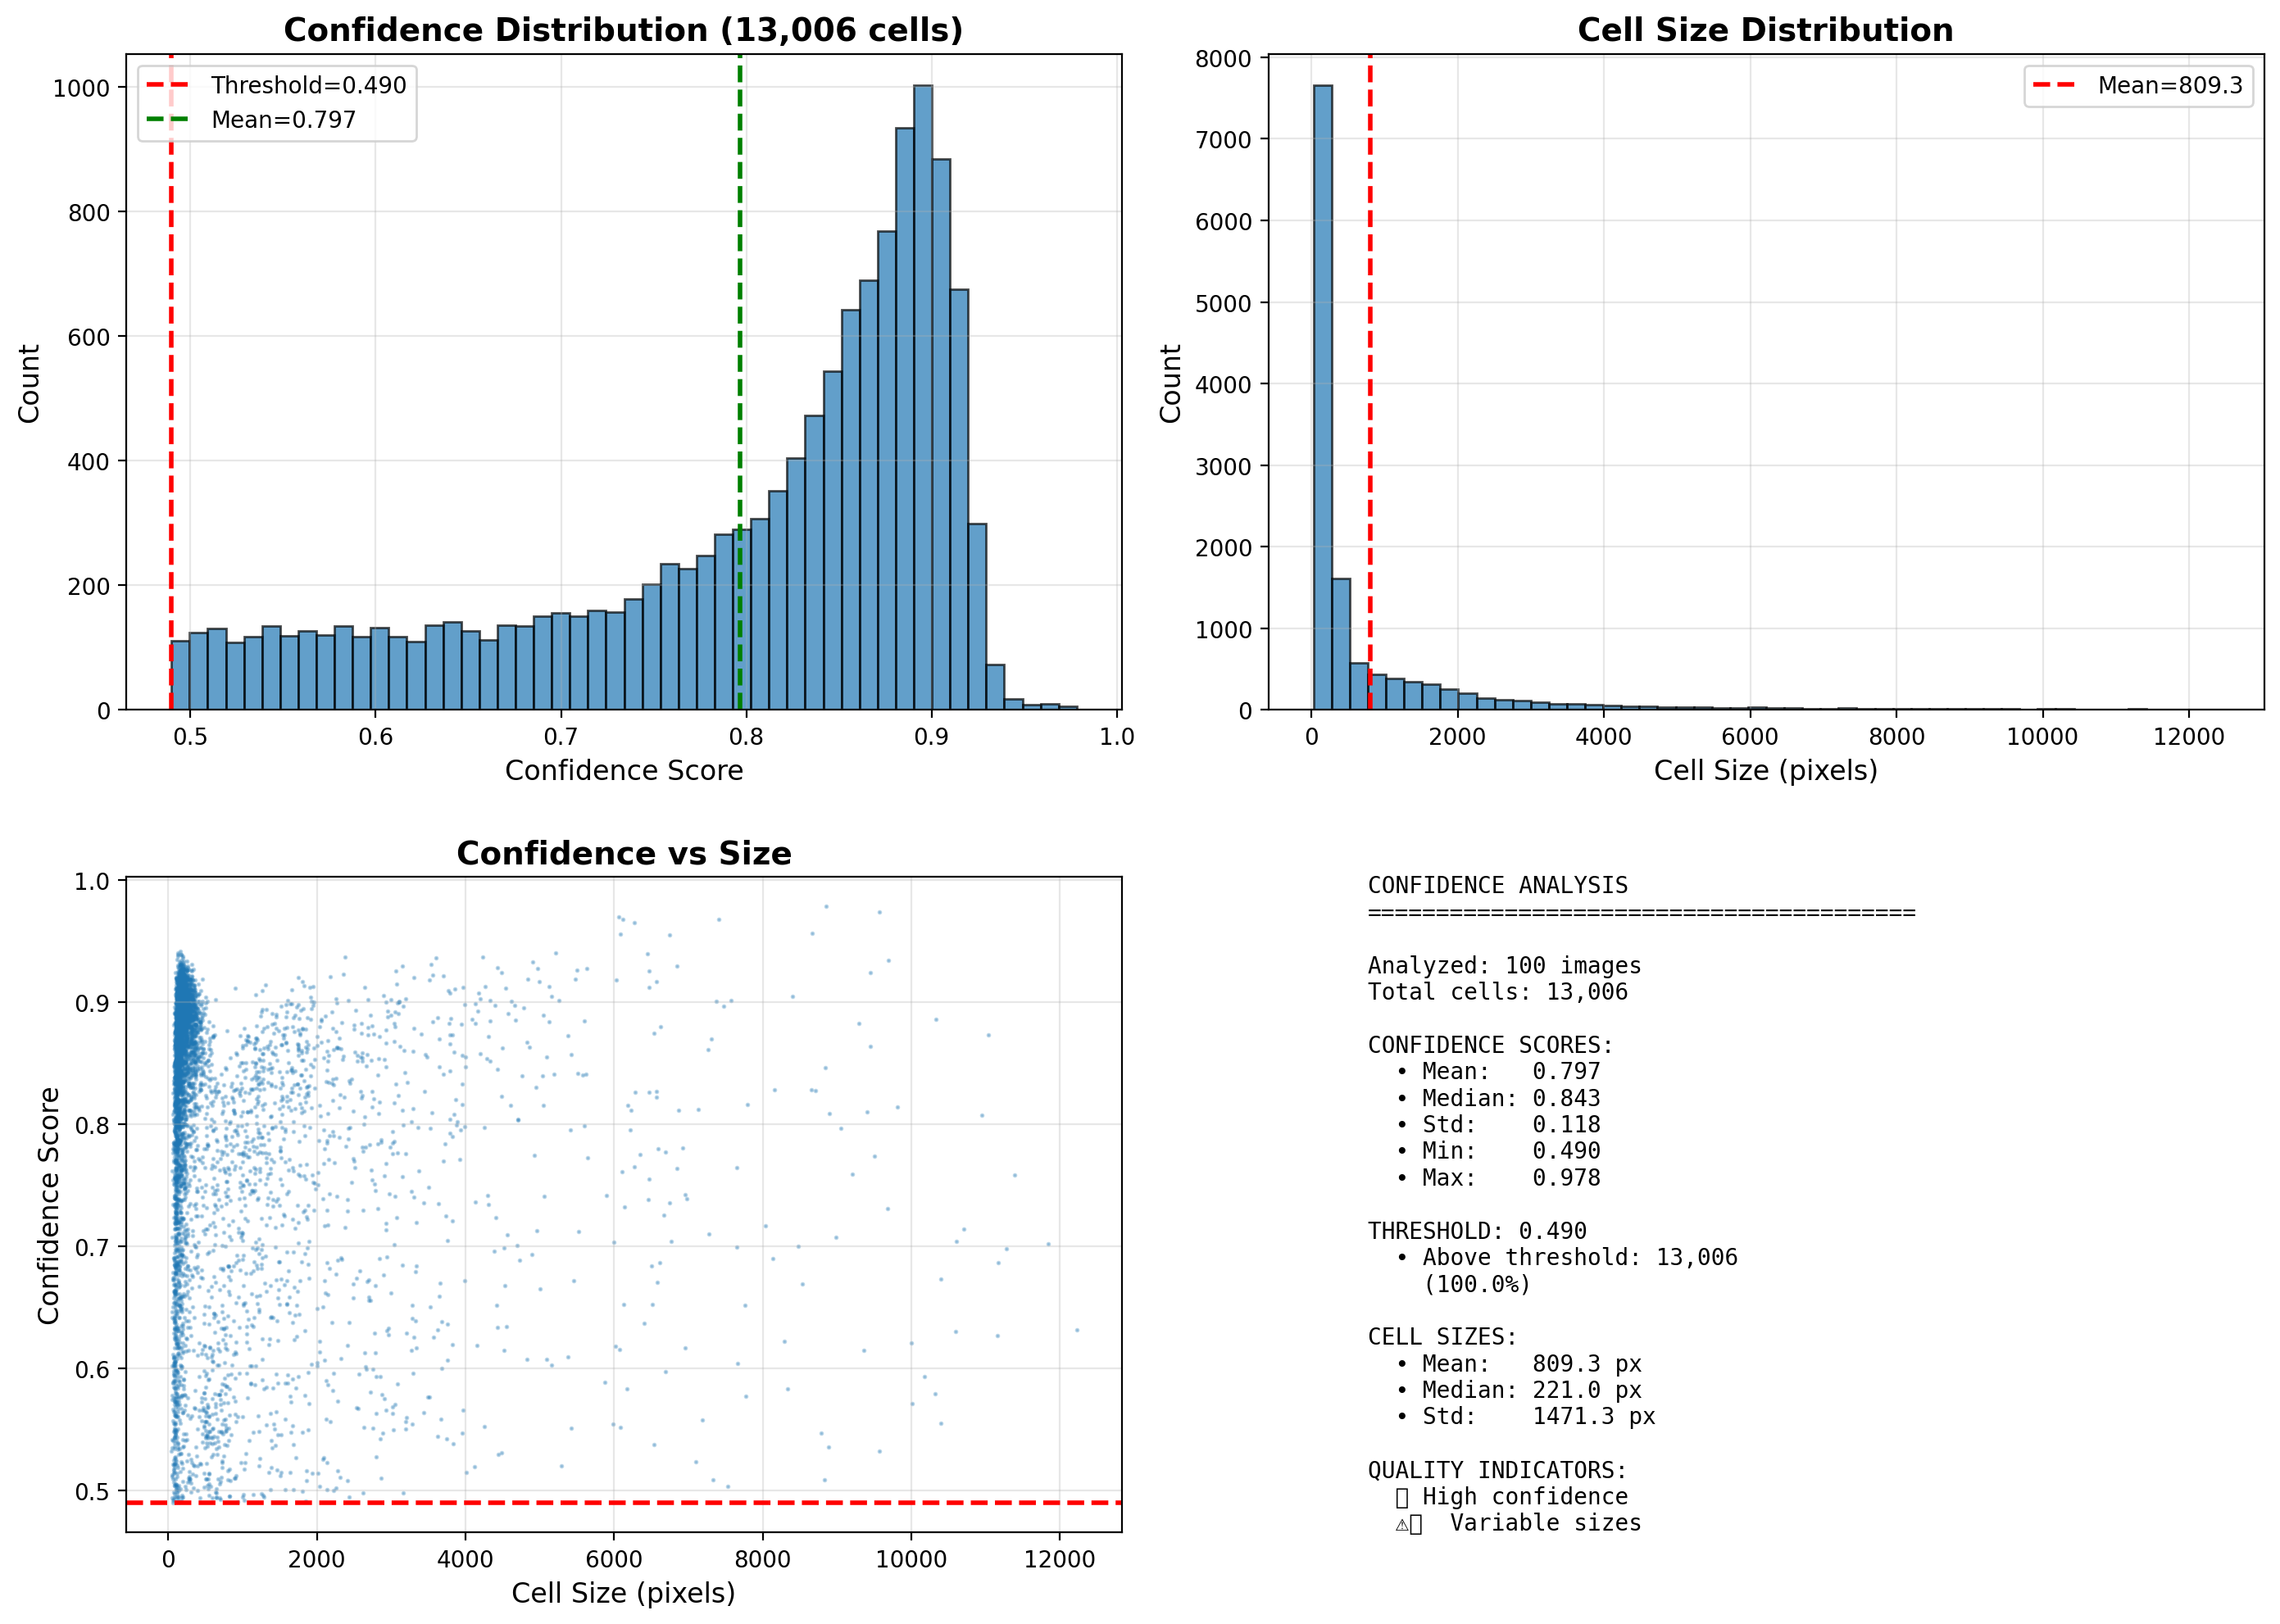


✅ Analysis saved to: predictions/confidence_analysis.png

💡 INTERPRETATION (WITHOUT GROUND TRUTH)

✅ HIGH CONFIDENCE (mean=0.797)
   Model rất tự tin về predictions
   → Khả năng cao là chính xác

💡 KHUYẾN NGHỊ:
   Để có metrics chính xác, nên:
   1. Annotate ít nhất 100 ảnh làm ground truth
   2. Chạy PHẦN A để tính Precision/Recall
   3. Dựa vào kết quả để điều chỉnh model


In [14]:
if has_ground_truth:
    print("Bỏ qua - đã có metrics chính xác")
else:
    print("⏳ Analyzing confidence scores...")
    
    # Sample 100 ảnh để analyze
    n_analyze = min(100, len(frame_files))
    analyze_files = frame_files[:n_analyze]
    
    all_probs = []
    all_sizes = []
    
    for frame_file in tqdm(analyze_files, desc="Analyzing"):
        img = np.array(Image.open(frame_file))
        img_norm = normalize(img, 1, 99.8, axis=(0, 1))
        
        labels, details = model.predict_instances(img_norm, n_tiles=model._guess_n_tiles(img_norm))
        
        if len(details['prob']) > 0:
            all_probs.extend(details['prob'])
        
        # Cell sizes
        for label_id in np.unique(labels)[1:]:
            size = np.sum(labels == label_id)
            all_sizes.append(size)
    
    all_probs = np.array(all_probs)
    all_sizes = np.array(all_sizes)
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Confidence distribution
    ax = axes[0, 0]
    ax.hist(all_probs, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(model.thresholds.prob, color='red', linestyle='--', linewidth=2, 
              label=f'Threshold={model.thresholds.prob:.3f}')
    ax.axvline(all_probs.mean(), color='green', linestyle='--', linewidth=2,
              label=f'Mean={all_probs.mean():.3f}')
    ax.set_xlabel('Confidence Score', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Confidence Distribution ({len(all_probs):,} cells)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Cell size distribution
    ax = axes[0, 1]
    ax.hist(all_sizes, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(all_sizes.mean(), color='red', linestyle='--', linewidth=2,
              label=f'Mean={all_sizes.mean():.1f}')
    ax.set_xlabel('Cell Size (pixels)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Cell Size Distribution', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Confidence by size
    ax = axes[1, 0]
    # Downsample for plotting
    plot_indices = np.random.choice(len(all_probs), min(5000, len(all_probs)), replace=False)
    ax.scatter(all_sizes[plot_indices], all_probs[plot_indices], alpha=0.3, s=1)
    ax.axhline(model.thresholds.prob, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Cell Size (pixels)', fontsize=12)
    ax.set_ylabel('Confidence Score', fontsize=12)
    ax.set_title('Confidence vs Size', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Statistics
    ax = axes[1, 1]
    ax.axis('off')
    
    stats_text = f"""
CONFIDENCE ANALYSIS
{'='*40}

Analyzed: {n_analyze} images
Total cells: {len(all_probs):,}

CONFIDENCE SCORES:
  • Mean:   {all_probs.mean():.3f}
  • Median: {np.median(all_probs):.3f}
  • Std:    {all_probs.std():.3f}
  • Min:    {all_probs.min():.3f}
  • Max:    {all_probs.max():.3f}

THRESHOLD: {model.thresholds.prob:.3f}
  • Above threshold: {np.sum(all_probs >= model.thresholds.prob):,}
    ({np.sum(all_probs >= model.thresholds.prob)/len(all_probs):.1%})

CELL SIZES:
  • Mean:   {all_sizes.mean():.1f} px
  • Median: {np.median(all_sizes):.1f} px
  • Std:    {all_sizes.std():.1f} px

QUALITY INDICATORS:
{'  ✅ High confidence' if all_probs.mean() > 0.7 else '  ⚠️  Moderate confidence'}
{'  ✅ Consistent sizes' if all_sizes.std()/all_sizes.mean() < 0.5 else '  ⚠️  Variable sizes'}
"""
    
    ax.text(0.1, 0.5, stats_text, fontsize=10, family='monospace',
           verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig('predictions/confidence_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Analysis saved to: predictions/confidence_analysis.png")
    
    # Interpretation
    print(f"\n{'='*70}")
    print("💡 INTERPRETATION (WITHOUT GROUND TRUTH)")
    print(f"{'='*70}")
    
    if all_probs.mean() > 0.7:
        print(f"\n✅ HIGH CONFIDENCE (mean={all_probs.mean():.3f})")
        print(f"   Model rất tự tin về predictions")
        print(f"   → Khả năng cao là chính xác")
    elif all_probs.mean() > 0.5:
        print(f"\n⚠️ MODERATE CONFIDENCE (mean={all_probs.mean():.3f})")
        print(f"   Model có độ tự tin trung bình")
        print(f"   → Nên kiểm tra visual một số ảnh")
    else:
        print(f"\n❌ LOW CONFIDENCE (mean={all_probs.mean():.3f})")
        print(f"   Model không chắc chắn về predictions")
        print(f"   → Cần annotate ground truth để verify")
    
    print(f"\n💡 KHUYẾN NGHỊ:")
    print(f"   Để có metrics chính xác, nên:")
    print(f"   1. Annotate ít nhất 100 ảnh làm ground truth")
    print(f"   2. Chạy PHẦN A để tính Precision/Recall")
    print(f"   3. Dựa vào kết quả để điều chỉnh model")

---

## 📝 SUMMARY & RECOMMENDATIONS

In [15]:
print("="*70)
print("📝 FINAL SUMMARY")
print("="*70)

if has_ground_truth:
    print(f"\n✅ METRICS COMPUTED ON {n_eval} IMAGES")
    print(f"\n📊 Main Results @ IoU 0.5:")
    print(f"   Precision: {precision:.1%}")
    print(f"   Recall:    {recall:.1%}")
    print(f"   F1-Score:  {f1:.1%}")
    
    print(f"\n📁 Output Files:")
    print(f"   • predictions/full_dataset_metrics.csv")
    print(f"   • predictions/full_dataset_metrics_visualization.png")
    print(f"   • predictions/per_image_metrics.csv")
    
    if recall >= 0.85:
        print(f"\n🎉 CONGRATULATIONS!")
        print(f"   Model đạt mục tiêu Recall >= 85%!")
    else:
        print(f"\n💡 TO IMPROVE RECALL:")
        print(f"   1. Giảm prob_threshold xuống 0.2-0.3")
        print(f"   2. Train với n_rays=96 hoặc 128")
        print(f"   3. Tăng augmentation")
else:
    print(f"\n⚠️ NO GROUND TRUTH AVAILABLE")
    print(f"\n📋 NEXT STEPS:")
    print(f"   1. Chọn 100 ảnh để annotate (đã tạo folder annotation_sample_100/)")
    print(f"   2. Annotate bằng Napari/QuPath/ImageJ")
    print(f"   3. Lưu masks vào ground_truth_800_frames/")
    print(f"   4. Chạy lại notebook để tính metrics chính xác")
    
    print(f"\n📊 Current Status (based on confidence):")
    if 'all_probs' in locals():
        print(f"   Mean confidence: {all_probs.mean():.3f}")
        print(f"   Total cells detected: {len(all_probs):,}")

print(f"\n{'='*70}")
print("✅ ANALYSIS COMPLETE!")
print("="*70)

📝 FINAL SUMMARY

⚠️ NO GROUND TRUTH AVAILABLE

📋 NEXT STEPS:
   1. Chọn 100 ảnh để annotate (đã tạo folder annotation_sample_100/)
   2. Annotate bằng Napari/QuPath/ImageJ
   3. Lưu masks vào ground_truth_800_frames/
   4. Chạy lại notebook để tính metrics chính xác

📊 Current Status (based on confidence):
   Mean confidence: 0.797
   Total cells detected: 13,006

✅ ANALYSIS COMPLETE!
